In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import electronbeam
from beam.elements import plasma
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
plt.rcParams['animation.ffmpeg_path'] = '/home/robert/anaconda3/envs/CU-PWFA/bin/ffmpeg'
import matplotlib.animation as animation

path = '/media/robert/Data_Storage/Data/Tests/Test_Electron_Beam/'

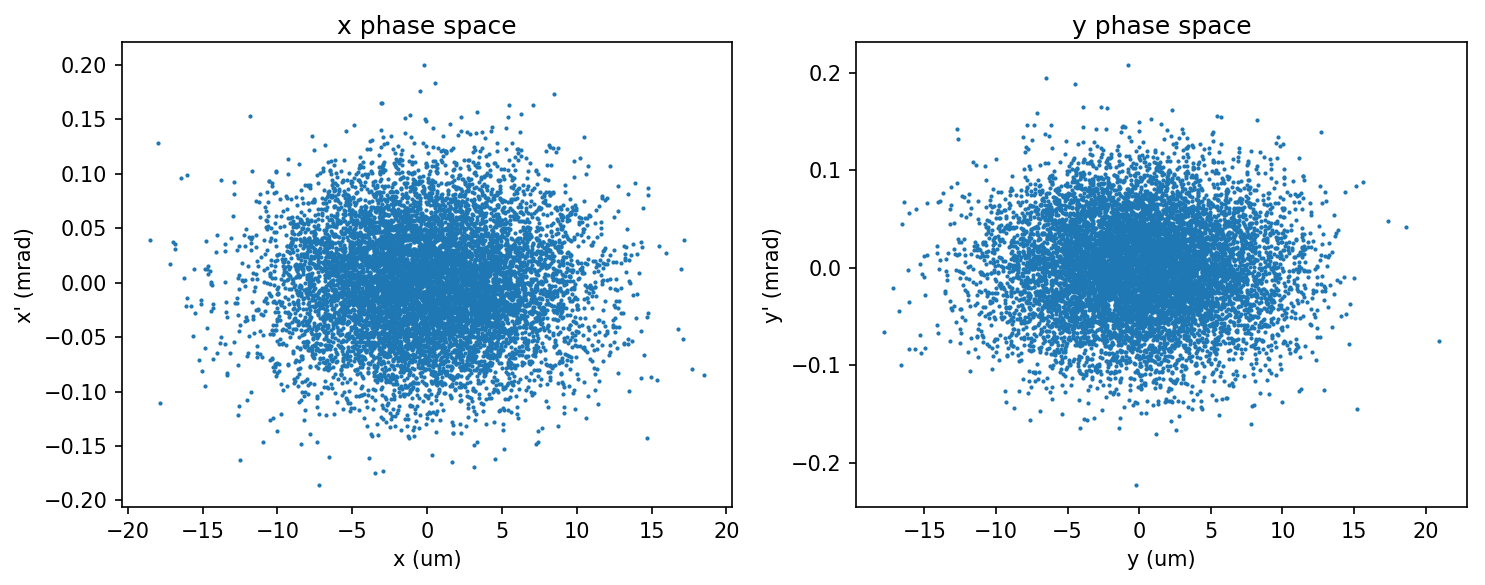

In [2]:
electronParams = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : 20000,
    'emittance' : 5e-6,
    'betax' : 0.10,
    'betay' : 0.10,
    'alphax' : 0.0,
    'alphay' : 0.0,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()

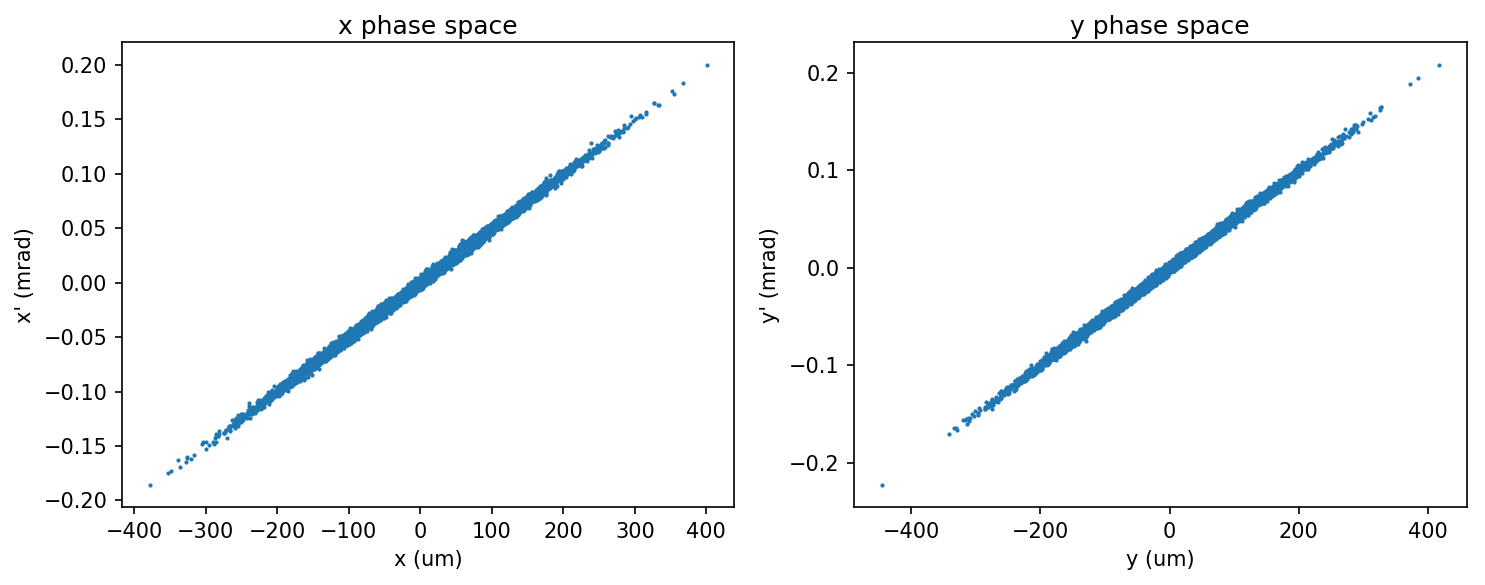

Initial emittance: 4.99465780681 mm.mrad
Final emittance: 4.99465780681 mm.mrad


In [3]:
# Now we can create a very simple plasma and propagate the beam through it
Nx = 50
Ny = 50
Nz = 3500
def dgammadz(ne):
    return 0.0
plasmaParams ={
    'name' : 'TestPlasma',
    'path' : path,
    'load' : False,
    'Nx' : Nx,
    'Ny' : Ny,
    'Nz' : Nz,
    'X' : 100,
    'Y' : 100,
    'Z' : 2e6,
    'n0' : 0.0,
    'atom' : ionization.Ar,
    'cyl' : False,
    'dgammadz' : dgammadz
}

argon = plasma.Plasma(plasmaParams)
n = plasmaParams['n0']*np.ones((Nx, Ny, Nz), dtype='double')
ne = np.zeros((Nx, Ny, Nz), dtype='double')
argon.initialize_plasma(n, ne)
interactions.electron_plasma(beam, argon, argon.z, 100)
beam.plot_current_phase()
print('Initial emittance:', np.average(beam.get_emittance_n(0))*1e6, 'mm.mrad')
print('Final emittance:', np.average(beam.get_emittance_n(35))*1e6, 'mm.mrad')

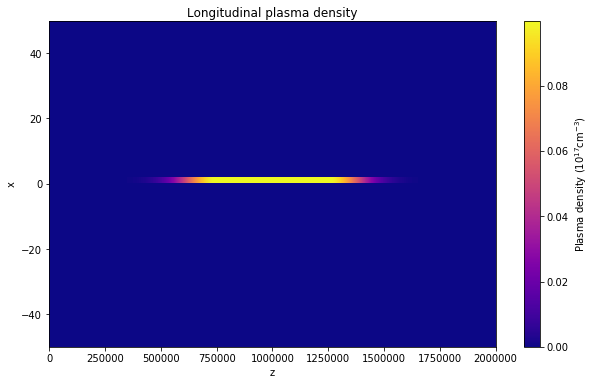

In [4]:
# Now we can create a very simple plasma and propagate the beam through it
Nx = 50
Ny = 50
Nz = 3500
def dgammadz(ne):
    return 0.0
plasmaParams ={
    'name' : 'TestPlasma',
    'path' : path,
    'load' : False,
    'Nx' : Nx,
    'Ny' : Ny,
    'Nz' : Nz,
    'X' : 100,
    'Y' : 100,
    'Z' : 2e6,
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'cyl' : False,
    'dgammadz' : dgammadz
}

argon = plasma.Plasma(plasmaParams)
n = plasmaParams['n0']*np.ones((Nx, Ny, Nz), dtype='double')
ne = np.zeros((Nx, Ny, Nz), dtype='double')
ne[int(Nx/2), int(Ny/2), :] = plasmaParams['n0']*profile.plasma_gaussian_ramps(0.75e6, 0.5e6, 12e4, 12e4, Nz,
                                                                               plasmaParams['Z'])[1]
argon.initialize_plasma(n, ne)
argon.plot_long_density_center()

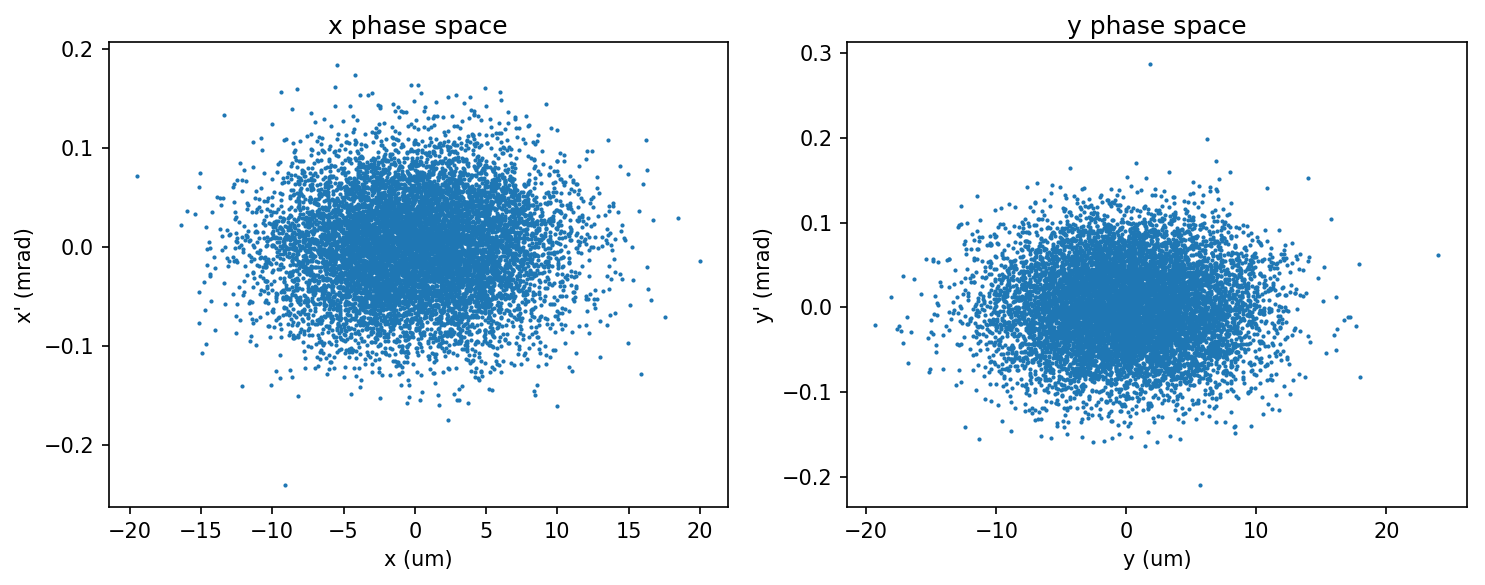

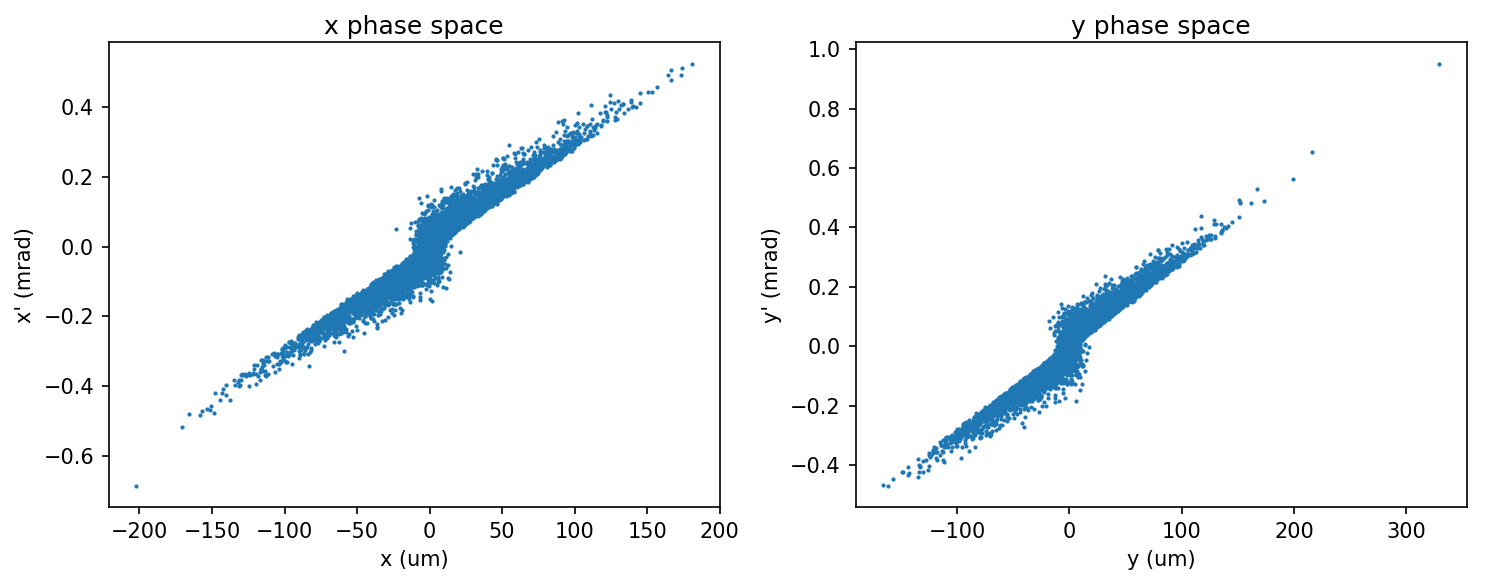

Initial emittance: 4.99049979364 mm.mrad
Final emittance: 20.6487481927 mm.mrad


In [5]:
beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()
interactions.electron_plasma(beam, argon, argon.z, 100)
beam.plot_current_phase()
print('Initial emittance:', np.average(beam.get_emittance_n(0))*1e6, 'mm.mrad')
print('Final emittance:', np.average(beam.get_emittance_n(35))*1e6, 'mm.mrad')

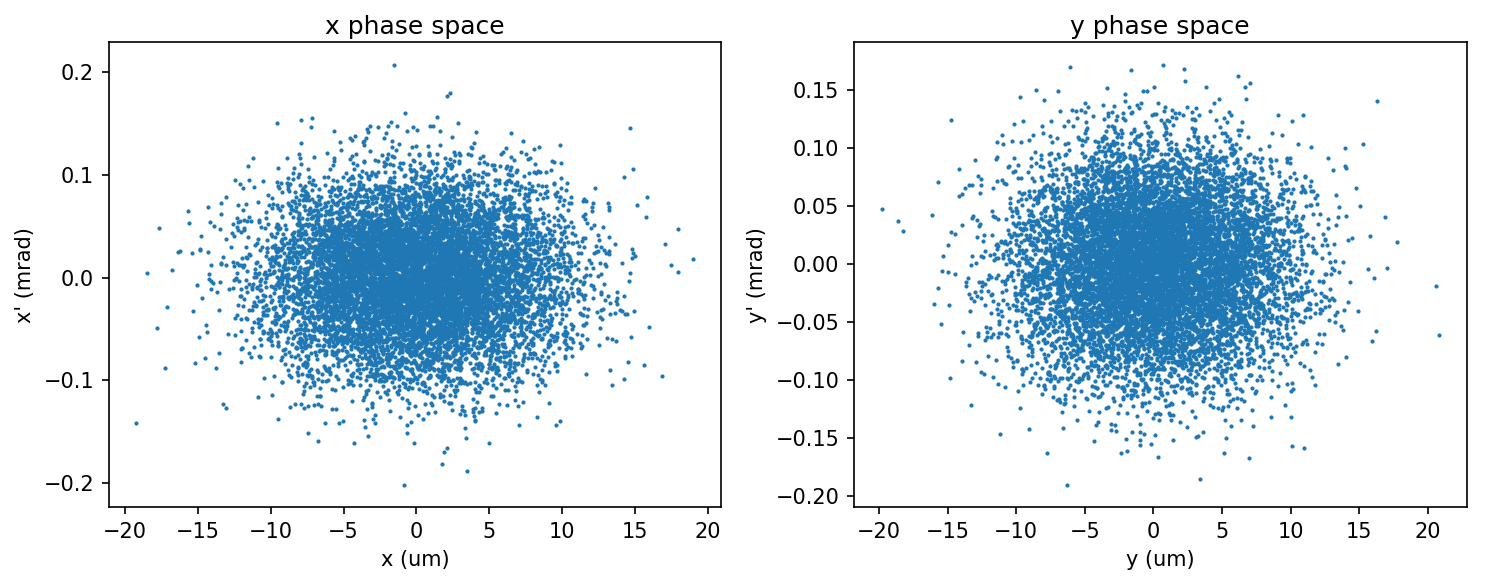

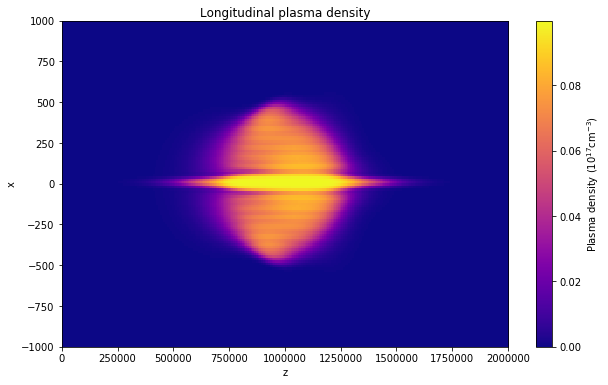

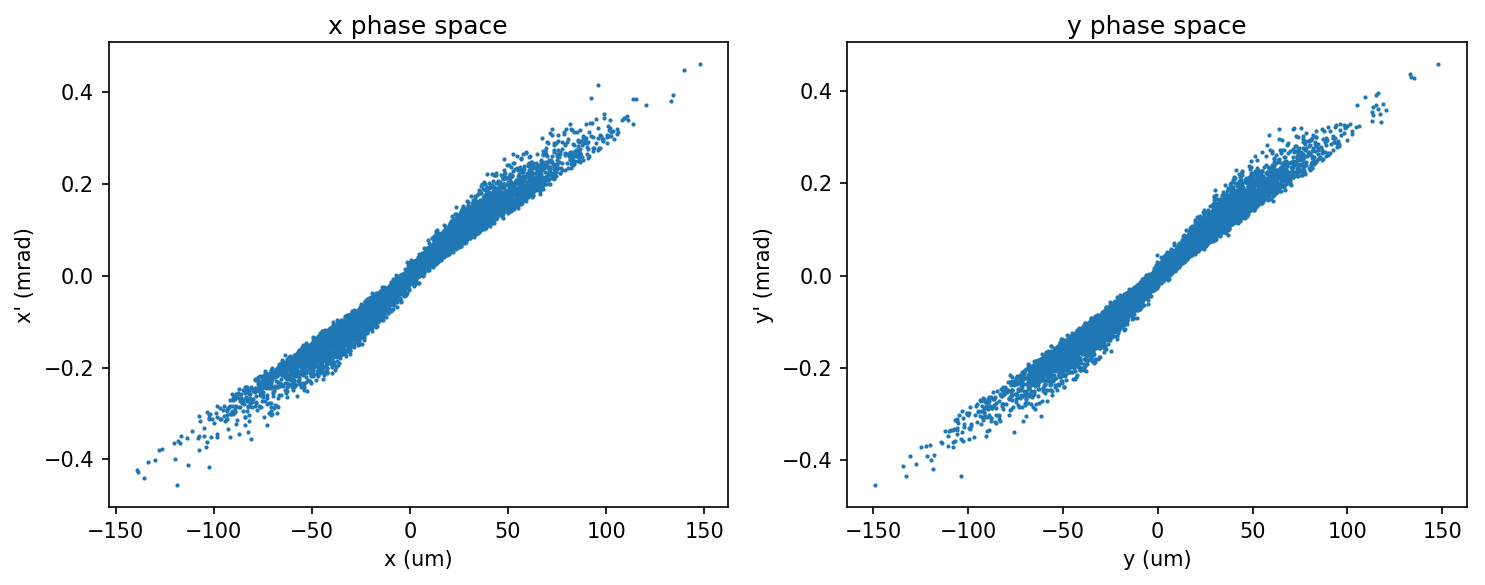

In [6]:
# Lets test this on one of my real plasmas
N = 3500
dumpPeriod = 2
loadPath ='/media/robert/Data_Storage/Data/Ionization/SphericalAndRamp/SecondAttempt_Sweeps/'
plasmaParams = np.load(loadPath+'elements/element_E0-150_waist-200_SPlasma/E0-150_waist-200_SPlasma_params.npy').item()
plasmaParams['path'] = path
plasmaParams['name'] = 'TestExistingPlasma'
plasmaParams['sourcePath'] = loadPath
plasmaParams['sourceName'] = 'E0-150_waist-200_SPlasma'
plasmaParams['dgammadz'] = dgammadz
argon = plasma.ExistingPlasma(plasmaParams)
for i in range(plasmaParams['Nz']-1):
    argon.save_plasma_density(argon.load_plasma_den(i), i)
beam = electronbeam.GaussianElectronBeam(electronParams)
beam.plot_current_phase()
argon.plot_long_density_center(lim=[-1000, 1000])
interactions.electron_plasma(beam, argon, np.linspace(0, plasmaParams['Z'], N), dumpPeriod)
beam.plot_current_phase()

In [7]:
m = int(N/dumpPeriod)
print('Initial emittance:', np.average(beam.get_emittance_n(0))*1e6, 'mm.mrad')
print('Final emittance:', np.average(beam.get_emittance_n(m))*1e6, 'mm.mrad')

Initial emittance: 5.00340439977 mm.mrad
Final emittance: 12.2024591559 mm.mrad


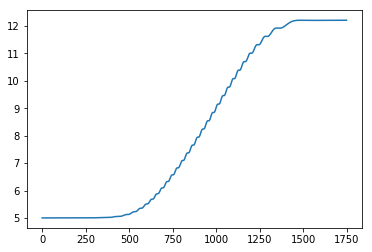

In [8]:
en = np.zeros(m, dtype='double')
for i in range(m):
    en[i] = np.average(beam.get_emittance_n(i))*1e6

plt.plot(en)
plt.show()

In [9]:
# Now time to animate phase space
ptcls, z = beam.load_ptcls(0)
fig, sctx, scty = beam.plot_phase(ptcls, z)
i = 1
def updatefig(*args):
    global i
    ptcls = beam.load_ptcls(i)[0]
    sctx.set_offsets(np.stack((ptcls[:, 0]*1e6, ptcls[:, 1]*1e3), axis=-1))
    scty.set_offsets(np.stack((ptcls[:, 2]*1e6, ptcls[:, 3]*1e3), axis=-1))
    i += 1
    return sctx, scty,
ani = animation.FuncAnimation(fig, updatefig, blit=True, frames=m-3)
ani.save(path + 'PhaseSpaceEvolution.mp4', fps=30)